# Smoke PM and Severity/Intensity

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from prescribed.utils import prepare_template

In [2]:
mtbs = gpd.read_file(
    "/mnt/sherlock/oak/prescribed_data/geoms/mtbs_perims_DD_updated/mtbs_perims_DD.shp"
)

mtbs_ca = mtbs[mtbs.Event_ID.str.startswith("CA")].to_crs(3310)
mtbs_ca["Ig_Date"] = pd.to_datetime(mtbs_ca.Ig_Date)
mtbs_ca["year"] = mtbs_ca.Ig_Date.dt.year

In [3]:
# Load data from templates
template = (
    prepare_template("/mnt/sherlock/oak/prescribed_data/geoms/templates/template.tif")
    .groupby("grid_id", as_index=False)
    .first()
    .drop(columns=["year"])
)

# Load land type
land_type = pd.read_feather(
    "/mnt/sherlock/oak/prescribed_data/processed/land_type/land_type.feather"
).drop(columns=["spatial_ref", "lat", "lon"], errors="ignore")

# Load smoke linked to fire events
smoke_pm = pd.read_feather(
    "/mnt/sherlock/oak/prescribed_data/processed/smoke_linking/smoke_pm_fire_event.feather"
)

# Get treatments according to template
treatments = (
    pd.read_feather(
        "/mnt/sherlock/oak/prescribed_data/processed/treatments_mtbs.feather"
    )
    .dropna(subset=["Event_ID"])
    .drop(columns=["spatial_ref"])
    .merge(template, on=["lat", "lon"], how="left")
)
treatments = treatments[treatments.Event_ID.isin(smoke_pm.Event_ID.tolist())]

# Load severity
severity = pd.read_feather(
    "/mnt/sherlock/oak/prescribed_data/processed/dnbr_gee_inmediate/dnbr_long.feather"
).drop(columns=["spatial_ref", "lat", "lon"], errors="ignore")

# Down-code dnbr to be zero if negative
severity.loc[severity.dnbr < 0, "dnbr"] = 0

In [4]:
conditions = [
    (severity.dnbr < 100),
    (severity.dnbr >= 100) & (severity.dnbr < 270),
    (severity.dnbr >= 270) & (severity.dnbr < 440),
    (severity.dnbr >= 440) & (severity.dnbr < 660),
    severity.dnbr >= 660,
]
choices = [0, 1, 2, 3, 4]

# Asigning FRP class to each fire
severity.loc[:, "class_dnbr"] = np.select(conditions, choices, default=np.nan)

In [5]:
# Get count of class_dnbr countrs by each event id and the total of rows per event
severity_agg = (
    severity.groupby(["event_id", "class_dnbr"])
    .size()
    .unstack()
    .reset_index()
    .fillna(0)
)
severity_agg["class_total"] = severity_agg.iloc[:, 1:].sum(axis=1)
severity_agg.columns = [
    f"class_{int(col)}" if isinstance(col, float) else col
    for col in severity_agg.columns
]

# Calculate shares per class and add Event_ID back
severity_agg_class = severity_agg.filter(regex="class_*").apply(
    lambda x: x / x["class_total"], axis=1
)
severity_agg_class["event_id"] = severity_agg["event_id"]

In [6]:
# Get most common land type for each event
event_land_type = (
    land_type.merge(treatments, on="grid_id", how="left")
    .dropna()
    .groupby("Event_ID", as_index=False)
    .land_type.agg(lambda x: x.value_counts().index[0])
)
event_land_type["land_type"] = event_land_type.land_type.astype(int).astype(str)

# Calculate mean dnbr per event and merge with smoke PM
mean_dnbr = severity.groupby("event_id", as_index=False).dnbr.mean()
mean_dnbr = (mean_dnbr
             .merge(smoke_pm, 
                    left_on="event_id", 
                    right_on="Event_ID", 
                    how="inner")
            .merge(event_land_type, on="Event_ID", how="inner")
            .merge(severity_agg_class, left_on="event_id", right_on="event_id", how="inner")
)

In [24]:
mtbs_land_type_year = event_land_type.merge(mtbs_ca[["Event_ID", "year"]], on="Event_ID", how="inner").land_type.value_counts()

In [26]:
231 / mtbs_land_type_year.sum()

0.45652173913043476

In [25]:
mtbs_land_type_year

land_type
12    231
2     208
3      34
5      21
8       7
4       2
1       1
11      1
13      1
Name: count, dtype: int64

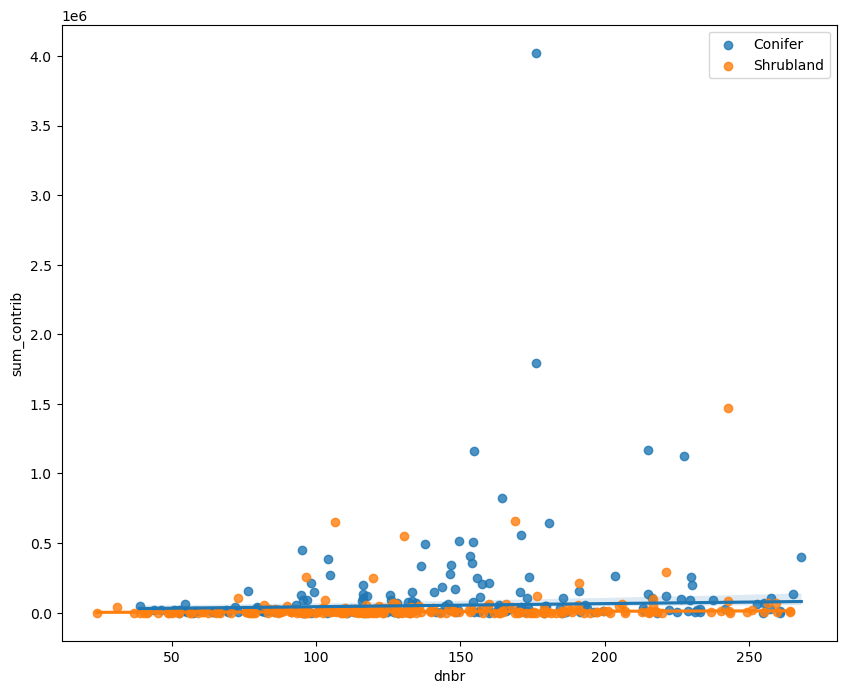

In [7]:
fig, ax = plt.subplots(figsize = (10, 8))

land_classes = {"2": "Conifer" , "12": "Shrubland"}

for lc, lc_name in land_classes.items():
    
    data = mean_dnbr[mean_dnbr.land_type == lc]

    sns.regplot(x="dnbr", 
                y="sum_contrib",
    data=data[(data.dnbr <= 270)],
    robust=True,
    ax=ax,
    label=lc_name)

ax.legend()

In [13]:
import os
from pathlib import Path

import xarray as xr
from tqdm import tqdm

data_proc = "/mnt/sherlock/oak/prescribed_data/processed/"
files_frp = list(Path(f"{data_proc}/frp").glob("*.nc4"))
save_path = "/mnt/sherlock/oak/prescribed_data/processed/frp/frp_parquet"
Path(save_path).mkdir(parents=True, exist_ok=True)

for file in tqdm(files_frp):
    frp = xr.open_dataset(file)
    ds = frp.to_dataframe().reset_index().dropna()
    ds = ds.drop(columns=["spatial_ref"], errors="ignore")
    
    ds = ds.merge(template, on=["lat", "lon"], how="left")
    ds.to_parquet(os.path.join(save_path, f"{file.stem}.parquet"))

  0%|          | 0/24 [00:00<?, ?it/s]

100%|██████████| 24/24 [14:36<00:00, 36.54s/it]


In [14]:
pd.read_parquet("/mnt/sherlock/oak/prescribed_data/processed/frp/frp_parquet/frp_modis_firms_2000.parquet")

,time,lat,lon,frp,grid_id
0,2000-11-01,48152.596997,-33913.82085,11.3,368572.0
1,2000-11-02,315152.596997,-107913.82085,12.5,123926.0
2,2000-11-02,154152.596997,-106913.82085,11.3,271403.0
3,2000-11-02,117152.596997,-227913.82085,47.9,305174.0
4,2000-11-02,117152.596997,-226913.82085,93.6,305175.0
...,...,...,...,...,...
448,2000-12-27,-585847.403003,431086.17915,6.1,NaN
449,2000-12-29,-432847.403003,228086.17915,4.2,809430.0
450,2000-12-29,-471847.403003,288086.17915,5.7,845214.0
451,2000-12-30,114152.596997,-202913.82085,14.2,307947.0
